Here, you develop the exact spatial derivative operator and its unit test.

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh = 32
refRatio = 2
CFL = 0.5
permitivity = 1.
permeability = 1.
L = 1.
nt = 63
x_0 = 0.
x_1 = 0.5
wavenumber = 7
Hans = False

In [17]:
c = 1
b = np.ones(8, float)
print(max(c) == ())
print(np.shape(b)[0])

TypeError: 'int' object is not iterable

In [3]:
def GaussParams(x_0 = 0., x_1 = 1., errOrd = 14):
    mu = (x_0 + x_1) / 2.
    sigma = abs((x_1 - x_0) / np.sqrt(8 * errOrd * log(10)))
    return mu, sigma

In [4]:
def ConvertParams(epsilon, mu, L):
    v = 1. / (L * np.sqrt(epsilon * mu))
    return v

In [5]:
omega = BT.Grid(nh)
finehalf = list(np.arange(int(nh / refRatio)))# + int(nh / refRatio))
omega.AddPatch(refRatio, finehalf)
degFreed = omega.degFreed
nh_min = omega.nh_min
nh_max = omega.nh_max
c = ConvertParams(permitivity, permeability, L)
t, nt = ST.CalcTime(omega, CFL, c, nt = nt)
mu, sigma = GaussParams(x_0, x_1)
waves = WT.MakeWaves(omega)
nullspace = OT.FindNullspace(omega, waves, Hans = Hans)
restrictOp = GTT.CoarsenOp(omega)
print('sig:', sigma, 'mu:', mu)

omegaF = BT.Grid(nh_max)
wavesF = WT.MakeWaves(omegaF)
omegaC = BT.Grid(nh_min)
wavesC = WT.MakeWaves(omegaC)

derivMat = TT.ExactSpatOp(omega)
spatOp = -c * derivMat
timePropOp = LA2.expm(t * spatOp)

derivMatC = TT.ExactSpatOp(omegaC)
spatOpC = -c * derivMatC
timePropOpC = LA2.expm(t * spatOpC)


sig: 0.03113530673812129 mu: 0.25
[[  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   1.   0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0

In [6]:
waves = WT.MakeWaves(omega)
nullspace = OT.FindNullspace(omega, waves)
# PT.PlotWaves(omega, waves = waves)
t, nt = ST.CalcTime(omega, CFL, c, nt = nt)
timePropOp = LA2.expm(t * spatOp)

In [7]:
# For Gaussian:
waveInitF = WFT.Gauss(omegaF, sigma, mu)
waveInitC = WFT.Gauss(omegaC, sigma, mu)
FCoefsC = FFTT.FourierCoefs(omegaC, wavesC, waveInitC)
FCoefsF = FFTT.FourierCoefs(omegaF, wavesF, waveInitF)

# Find initial waveform on coarse, fine, and AMR grids.
waveInitC = wavesC @ FCoefsC
waveInitF = wavesF @ FCoefsF
waveInitAMR = restrictOp @ waveInitF

# Find Fourier coefficients for initial condition on AMR grid.
FCoefsAMR = FFTT.FourierCoefs(omega, waves @ nullspace, waveInitAMR)
print('initial Coarse:')
print(np.round(FCoefsC, 14))
print('initial Fine:')
print(np.round(FCoefsF, 14))
print('initial AMR:')
print(np.round(FCoefsAMR, 14))
print('')

# Find propagated coeficients on coarse and fine grid.
FCoefsPropC = timePropOpC @ FCoefsC
FCoefsPropF = timePropOp @ FCoefsF

# Find propagated waveform on AMR grid.
wavePropAMR = restrictOp @ wavesF @ FCoefsPropF

# Find propagated coefficients on AMR grid.
FCoefsPropAMR = FFTT.FourierCoefs(omega, waves @ nullspace, wavePropAMR)

print(FCoefsPropC)
print(FCoefsPropF)
print(np.round(FCoefsPropAMR, 14))

# Find theoretical propagated coefficients on coarse, fine, and AMR grid.
FCoefsPropCTh = FFTT.PropRestrictWaves(omegaC, waveInitC, c * t)
FCoefsPropFTh = FFTT.PropRestrictWaves(omegaF, waveInitF, c * t)
FCoefsPropAMRTh = FFTT.PropRestrictWaves(omega, waveInitF, c * t)

print('')
print(np.round(FCoefsPropCTh, 14))
print(np.round(FCoefsPropFTh, 14))
print(np.round(FCoefsPropAMRTh, 14))

allCoefsC = PT.Load(FCoefsC, FCoefsPropC, FCoefsPropCTh)
allCoefsF = PT.Load(FCoefsF, FCoefsPropF, FCoefsPropFTh)
allCoefsAMR = PT.Load(FCoefsAMR, FCoefsPropAMR, FCoefsPropAMRTh)

labels = ['Initial Wave', 'Exact Derivative Propagated Wave', 'Rotation Matrix Propagated Wave']


initial Coarse:
[ 0.07804464  0.15313086 -0.          0.         -0.14458778 -0.13139527 -0.          0.          0.11492305  0.0967417  -0.          0.         -0.07837892 -0.06111713 -0.         -0.          0.04586711  0.03312844  0.         -0.         -0.02302549 -0.01539287 -0.          0.          0.00987944  0.00604386 -0.          0.         -0.00342252 -0.00156024 -0.          0.        ]
initial Fine:
[ 7.80446402e-02  1.53130855e-01 -0.00000000e+00  0.00000000e+00 -1.44587783e-01 -1.31395276e-01 -0.00000000e+00  0.00000000e+00  1.14923055e-01  9.67417264e-02 -0.00000000e+00  0.00000000e+00 -7.83790086e-02 -6.11174123e-02 -0.00000000e+00 -0.00000000e+00  4.58679586e-02  3.31308917e-02 -0.00000000e+00  0.00000000e+00 -2.30322358e-02 -1.54105569e-02 -0.00000000e+00  0.00000000e+00  9.92384169e-03  6.15064388e-03 -0.00000000e+00  0.00000000e+00 -3.66893990e-03 -2.10639528e-03 -0.00000000e+00  0.00000000e+00  1.16390735e-03  6.18979416e-04 -0.00000000e+00  0.00000000e+00 -3.1682

Are you *sure* your labels are ordered correctly?


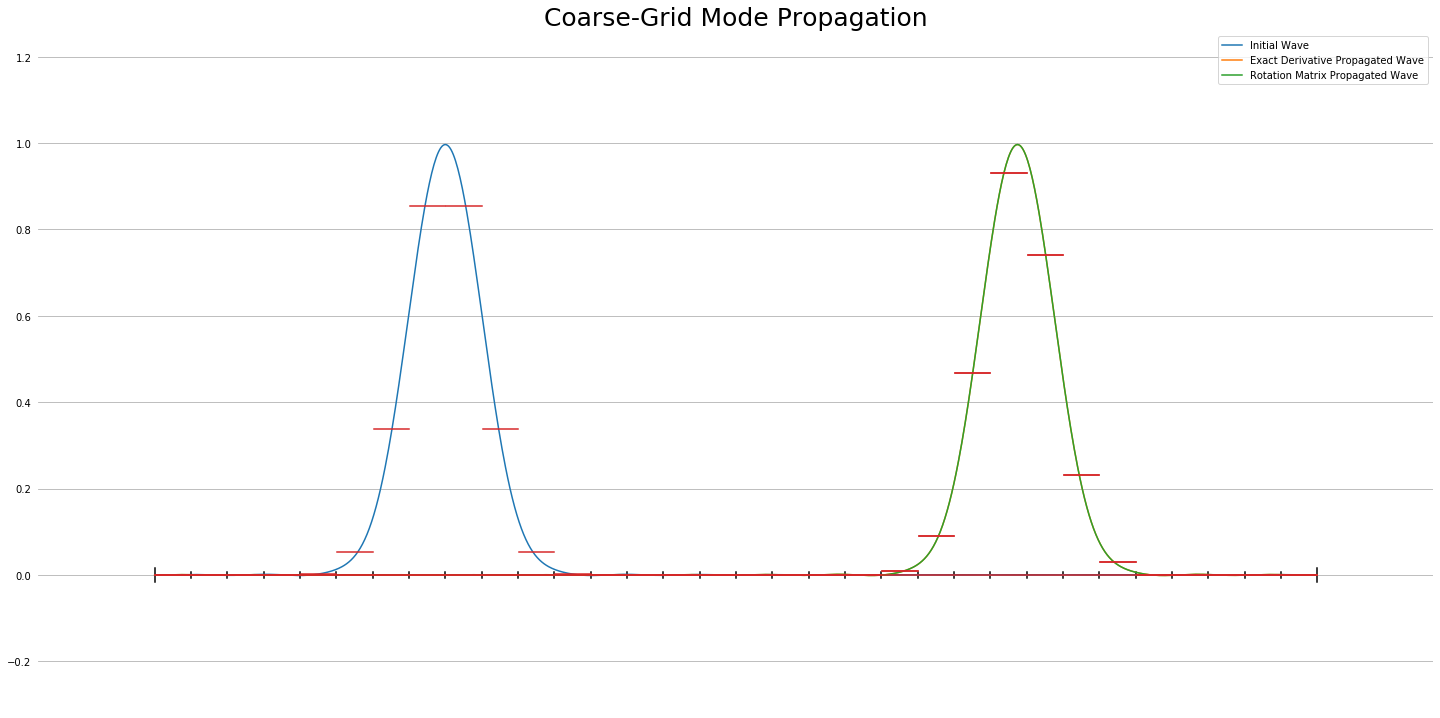

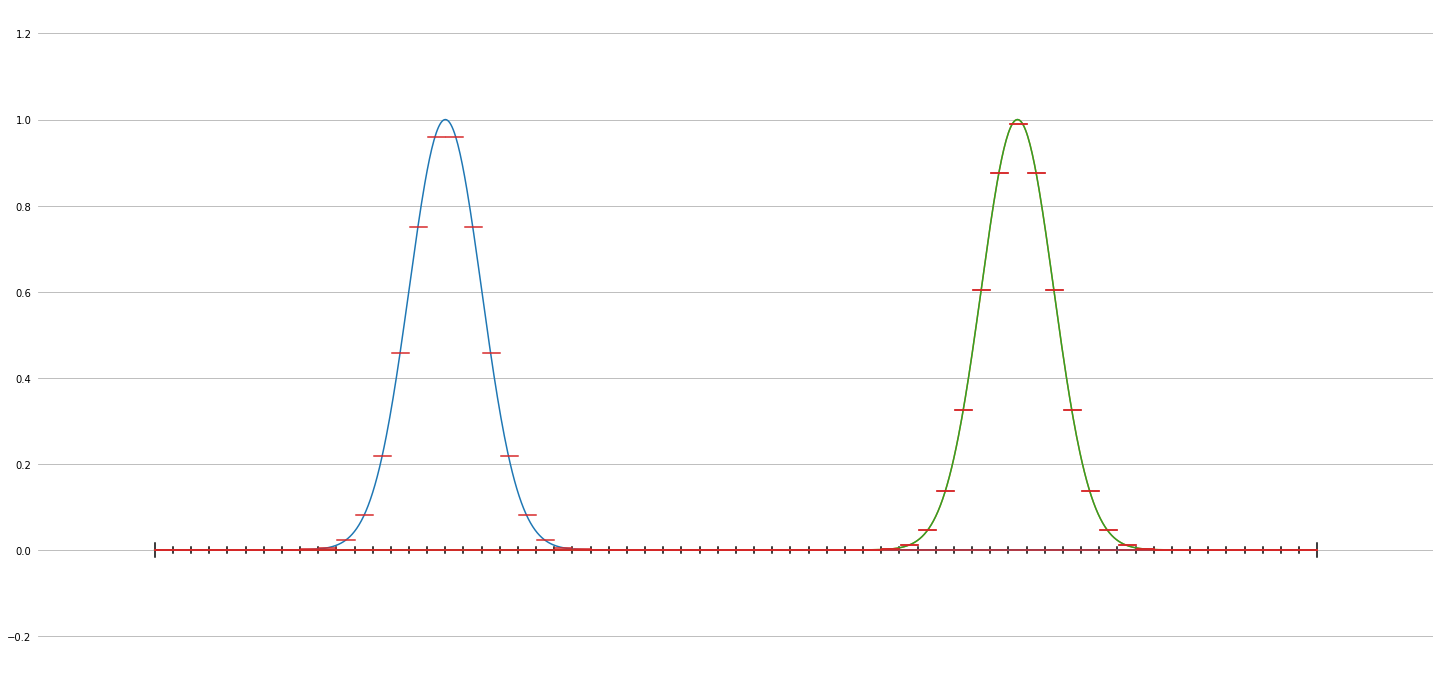

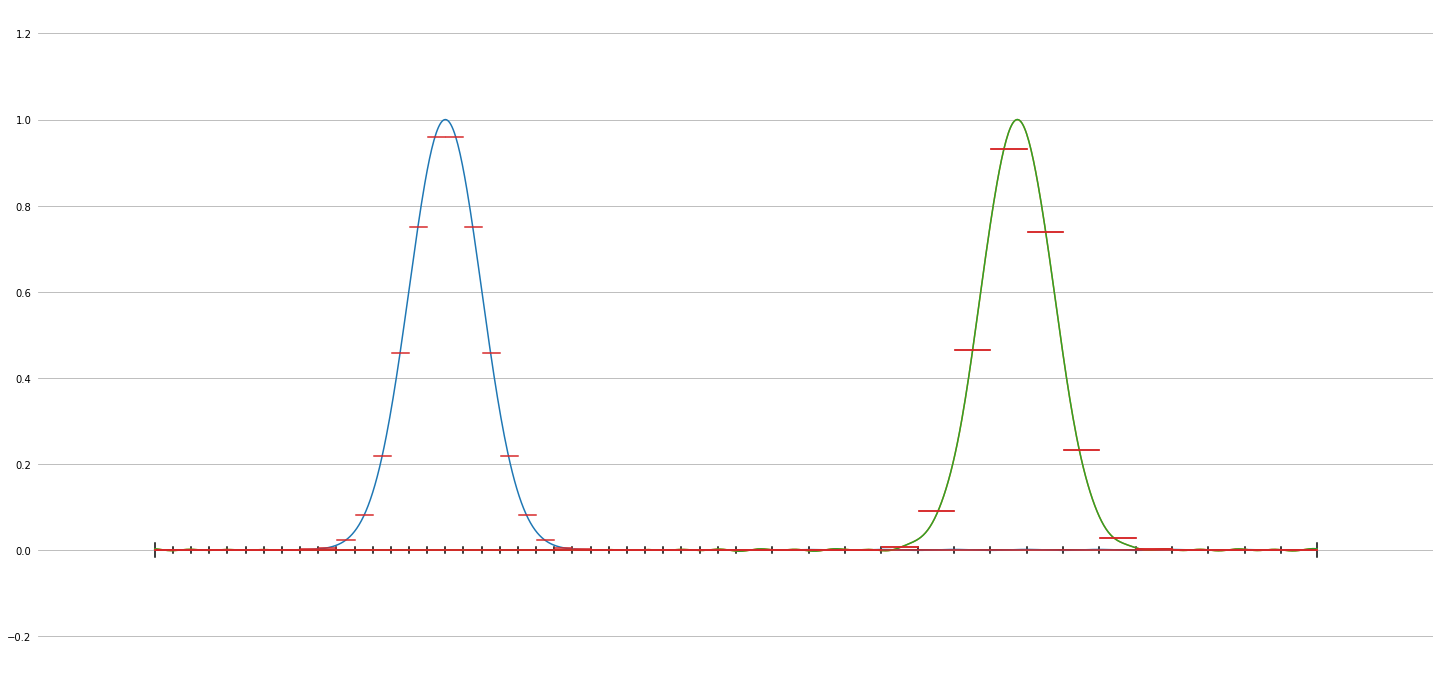

In [8]:
PT.PlotMixedWave(omegaC, waves = wavesC, FCoefs = allCoefsC, rescale = 5, yGrid = True, labels = labels, title = 'Coarse-Grid Mode Propagation')#, saveName = 'Coarse', dpi = 300)
PT.PlotMixedWave(omegaF, waves = wavesF, FCoefs = allCoefsF, rescale = 5, yGrid = True)#, labels = labels, title = 'Fine-Grid Mode Propagation', saveName = 'Fine', dpi = 300)
PT.PlotMixedWave(omega, waves = waves, FCoefs = nullspace @ allCoefsAMR, rescale = 5, yGrid = True)#, labels = labels, title = 'AMR-Grid Mode Propagation', saveName = 'AMRHansMethod', dpi = 300)


In [9]:
# Notes for Hans:
#
# If the resolution is too low, there isn't sufficient high-frequency content to represent the gaussian.
# Sparse function needs to be developed for upwind and center-diffference of arbitrary-order polynomial interpolation.


In [ ]:
# Notes for Sasha:
#
# Make residuals test of Gaussian (first unpropagated, then unpropagated) to assess its validity.
